In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from fasterrisk.binarization_util import convert_continuous_df_to_binary_df
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier
from fasterrisk.utils import download_file_from_google_drive

## Data Preprocessing

In [2]:
# Config
LABEL_COL = 'Cancer_lbl'
FEATURES_STLMD  = ['sct_long_dia','part_solid','ground_glass','solid','Upper_Lobe','Spiculation','age','sex']
FEATURES_STLM   = ['sct_long_dia','part_solid','ground_glass','solid','Upper_Lobe','Spiculation']
FEATURES_STPGLM = ['sct_long_dia','part_solid','ground_glass','Upper_Lobe','Spiculation']

CSV1 = 'ml_dataset/nlst_ct_nodule_df_set1.csv'
CSV2 = 'ml_dataset/nlst_ct_nodule_df_set2.csv'

### Helpers

筛选掉gender和nodule type不对的行

In [3]:
def filter_and_report(df: pd.DataFrame) -> pd.DataFrame:
    initial_len = len(df)
    df = df[df['gender'].isin(['male', 'female'])]
    df = df[df['Nodule_Type'].isin(['solid', 'ground-glass', 'part-solid'])]
    print(f"[filter] Removed {initial_len - len(df)} rows (invalid gender or Nodule_Type).")
    return df

将y转换为-1或1

In [4]:
def to_fastrisk_y(y_raw, pos_label=1) -> np.ndarray:
    """Return 1-D np.ndarray[float] with labels in {-1.0, +1.0}."""
    y_arr = np.asarray(y_raw).ravel()
    uniq = set(np.unique(y_arr))
    if uniq <= {0, 1}:
        return (2 * y_arr - 1).astype(float)
    return np.where(y_arr == pos_label, 1.0, -1.0).astype(float)

让test set和training set中的特征一样

In [5]:
def align_like_train(train_bin_df: pd.DataFrame, other_bin_df: pd.DataFrame) -> pd.DataFrame:
    """Make other_bin_df have exactly the same columns and order as train_bin_df."""
    cols = list(train_bin_df.columns)
    return other_bin_df.reindex(columns=cols, fill_value=0)

拆成x和y

In [6]:
def prepare_data(df: pd.DataFrame, feature_cols, label_col):
    X = df[feature_cols]
    y = df[label_col]
    return X, y

In [7]:
def binarize_and_align(X_train_df: pd.DataFrame, X_val_df: pd.DataFrame, X_test_df: pd.DataFrame):
    """Binarize each split, then align val/test to training columns."""
    X_train_bin = convert_continuous_df_to_binary_df(X_train_df)
    X_val_bin   = convert_continuous_df_to_binary_df(X_val_df)
    X_test_bin  = convert_continuous_df_to_binary_df(X_test_df)
    X_val_bin   = align_like_train(X_train_bin, X_val_bin)
    X_test_bin  = align_like_train(X_train_bin, X_test_bin)
    # sanity
    assert list(X_val_bin.columns)  == list(X_train_bin.columns)
    assert list(X_test_bin.columns) == list(X_train_bin.columns)
    return X_train_bin, X_val_bin, X_test_bin

## Remove age>70

Bias: 只有高概率患癌的患者才会在年老的时候进行检查。故去掉age>70的病例

In [8]:
def filter_age_le_70(df):
    return df[df['age'] <= 70]

In [9]:
def replace_and_invert(df):
    '''Replace columns with '<=' in their names by '>' and invert their binary values.'''
    for col in list(df.columns):
        if '<=' in col:
            new_col = col.replace('<=', '>')
            df[col] = 1 - df[col].astype(int)
            df.rename(columns={col: new_col}, inplace=True)
    return df

### basic encode

In [10]:
# -------------------------
# Load, filter, encode
# -------------------------
df1 = pd.read_csv(CSV1)
df2 = pd.read_csv(CSV2)

df1 = filter_and_report(df1)
df2 = filter_and_report(df2)

df1 = filter_age_le_70(df1)
df2 = filter_age_le_70(df2)

# Encode needed variables
for df in (df1, df2):
    df['sex'] = df['gender'].map({'male': 0, 'female': 1})
    df['part_solid']   = df['Nodule_Type'].apply(lambda x: 1 if 'part-solid'   in x else 0)
    df['ground_glass'] = df['Nodule_Type'].apply(lambda x: 1 if 'ground-glass' in x else 0)
    df['solid']        = df['Nodule_Type'].apply(lambda x: 1 if 'solid'        in x else 0)

# -------------------------
# Patient-level stratified split (on df1)
# -------------------------
patients = df1[['pid', LABEL_COL]].drop_duplicates()
train_patients, val_patients = train_test_split(
    patients,
    test_size=0.2,
    stratify=patients[LABEL_COL],
    random_state=42
)
train_df = df1[df1['pid'].isin(train_patients['pid'])]
val_df   = df1[df1['pid'].isin(val_patients['pid'])]

# ============================================================
# STLMD (includes age & sex)
# ============================================================
X_train_STLMD_df, y_train_STLMD_raw = prepare_data(train_df, FEATURES_STLMD, LABEL_COL)
X_val_STLMD_df,   y_val_STLMD_raw   = prepare_data(val_df,   FEATURES_STLMD, LABEL_COL)
X_test_STLMD_df,  y_test_STLMD_raw  = prepare_data(df2,      FEATURES_STLMD, LABEL_COL)

X_train_STLMD_bin, X_val_STLMD_bin, X_test_STLMD_bin = binarize_and_align(
    X_train_STLMD_df, X_val_STLMD_df, X_test_STLMD_df
)

X_train_STLMD_bin = replace_and_invert(X_train_STLMD_bin)
X_val_STLMD_bin   = replace_and_invert(X_val_STLMD_bin)
X_test_STLMD_bin  = replace_and_invert(X_test_STLMD_bin)

y_train_STLMD = to_fastrisk_y(y_train_STLMD_raw, pos_label=1)
y_val_STLMD   = to_fastrisk_y(y_val_STLMD_raw,   pos_label=1)
y_test_STLMD  = to_fastrisk_y(y_test_STLMD_raw,  pos_label=1)

X_train_STLMD = X_train_STLMD_bin.to_numpy(dtype=float)
X_val_STLMD   = X_val_STLMD_bin.to_numpy(dtype=float)
X_test_STLMD  = X_test_STLMD_bin.to_numpy(dtype=float)

[filter] Removed 0 rows (invalid gender or Nodule_Type).
[filter] Removed 0 rows (invalid gender or Nodule_Type).
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous features to binary features......
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous features to binary features......
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous

检查x与y的shape，检查y是否为+—1

In [11]:
# -------------------------
# Quick hygiene checks
# -------------------------
def _chk(Xtr, ytr, Xv, yv, Xte, yte, name):
    assert Xtr.shape[0] == ytr.shape[0] and Xv.shape[0] == yv.shape[0] and Xte.shape[0] == yte.shape[0], f"row mismatch in {name}"
    assert set(np.unique(ytr)) <= {-1.0, 1.0} and set(np.unique(yv)) <= {-1.0, 1.0} and set(np.unique(yte)) <= {-1.0, 1.0}, f"bad labels in {name}"
    print(f"{name:7s} -> X_train {Xtr.shape}, X_val {Xv.shape}, X_test {Xte.shape}")

_chk(X_train_STLMD, y_train_STLMD, X_val_STLMD, y_val_STLMD, X_test_STLMD, y_test_STLMD, "STLMD")

STLMD   -> X_train (12401, 78), X_val (2997, 78), X_test (15144, 78)


## Try to replicate

In [12]:
def run_fasterrisk(
    X_train,
    y_train,
    k,
    gap_tolerance=0.05,
    parent_size=10,
    select_top_m=50,
    maxAttempts=50,
    num_ray_search=20,
    lineSearch_early_stop_tolerance=1e-3,
    lb=-5,
    ub=5,
    verbose=True,
):
    """
    Run FasterRisk and return the integer Rashomon set.

    Parameters
    ----------
    X_train : np.ndarray, shape (n, p)
        Training feature matrix (float)
    y_train : np.ndarray, shape (n,)
        Labels in {-1, +1}
    k : int
        Sparsity level (number of non-zero features)
    gap_tolerance : float
        Rashomon set tolerance (loss gap)
    parent_size : int
        Beam width in sparse beam search
    select_top_m : int
        Number of sparse diverse solutions to keep
    maxAttempts : int
        Max attempts per support swap
    num_ray_search : int
        Number of rays for integer scaling
    lineSearch_early_stop_tolerance : float
        Early stopping tolerance in ray search
    lb, ub : float or list
        Lower / upper bounds for coefficients
    verbose : bool
        Whether to print timing and model count

    Returns
    -------
    multipliers : np.ndarray, shape (M,)
    sparseDiversePool_beta0_integer : np.ndarray, shape (M,)
    sparseDiversePool_betas_integer : np.ndarray, shape (M, p)
    """

    # -------------------------
    # Initialize optimizer
    # -------------------------
    optimizer = RiskScoreOptimizer(
        X=X_train,
        y=y_train,
        k=k,
        parent_size=parent_size,
        gap_tolerance=gap_tolerance,
        select_top_m=select_top_m,
        maxAttempts=maxAttempts,
        num_ray_search=num_ray_search,
        lineSearch_early_stop_tolerance=lineSearch_early_stop_tolerance,
        lb=lb,
        ub=ub,
    )

    # -------------------------
    # Optimize
    # -------------------------
    start_time = time.time()
    optimizer.optimize()
    elapsed = time.time() - start_time

    # -------------------------
    # Get results
    # -------------------------
    multipliers, beta0_int, betas_int = optimizer.get_models()

    return multipliers, beta0_int, betas_int


In [13]:
multipliers, beta0_int, betas_int = run_fasterrisk(
    X_train=X_train_STLMD,
    y_train=y_train_STLMD,
    k=5,
    gap_tolerance=0.05,
    parent_size=10,
    select_top_m=71,
    maxAttempts=50,
    num_ray_search=20,
    lineSearch_early_stop_tolerance=1e-3,
    verbose=True
)

A function to turn the output weight matrix into a dataframe that is interpretable

In [14]:
def build_feature_model_matrix(
    sparseDiversePool_betas_integer,
    feature_names,
    model_prefix="model"
):
    """
    Parameters
    ----------
    sparseDiversePool_betas_integer : ndarray, shape (M, p)
        FasterRisk output
    feature_names : list[str], length p
        feature names
    model_prefix : str

    Returns
    -------
    df : pd.DataFrame
        row=feature，column=model，values=weights
    """
    M, p = sparseDiversePool_betas_integer.shape
    assert len(feature_names) == p

    df = pd.DataFrame(
        sparseDiversePool_betas_integer.T,
        index=feature_names,
        columns=[f"{model_prefix}_{i}" for i in range(M)]
    )
    return df

In [15]:
feature_model_df = build_feature_model_matrix(betas_int, feature_names=X_train_STLMD_bin.columns)
feature_model_df = feature_model_df[(feature_model_df != 0).any(axis=1)]

## Feature sets similar?

A function to draw picture according to the dataframe of models

In [16]:
def plot_feature_model_matrix(
    feature_model_df,
    figsize=(18, 8),
    pos_color="#E07A5F", 
    neg_color="#4D96FF", 
    base_size=120,
    save_path=None,
):
    features = feature_model_df.index.tolist()
    models   = feature_model_df.columns.tolist()

    fig, ax = plt.subplots(figsize=figsize)

    for i, feature in enumerate(features):
        for j, model in enumerate(models):
            coef = feature_model_df.loc[feature, model]

            if coef == 0:
                continue

            color = pos_color if coef > 0 else neg_color
            size  = base_size * abs(coef)

            ax.scatter(
                j, i,
                s=size,
                color=color,
                alpha=0.85,
                edgecolors="white",
                linewidth=0.8,
                zorder=3
            )

            ax.text(
                j, i,
                f"{int(coef)}",
                ha="center",
                va="center",
                fontsize=8,
                color="white",
                weight="bold",
                zorder=4
            )

    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(features)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=90)

    ax.invert_yaxis()
    ax.set_xlabel("Model (sorted by logistic loss)")
    ax.set_ylabel("Feature")

    ax.set_axisbelow(True)
    ax.grid(axis="x", linestyle="-", alpha=0.25)
    ax.grid(axis="y", linestyle=":", alpha=0.2)

    plt.tight_layout()

    # save if requested
    if save_path:
        dirpath = os.path.dirname(save_path)
        if dirpath:
            os.makedirs(dirpath, exist_ok=True)
        fig.savefig(save_path, dpi=300)
        plt.close(fig)


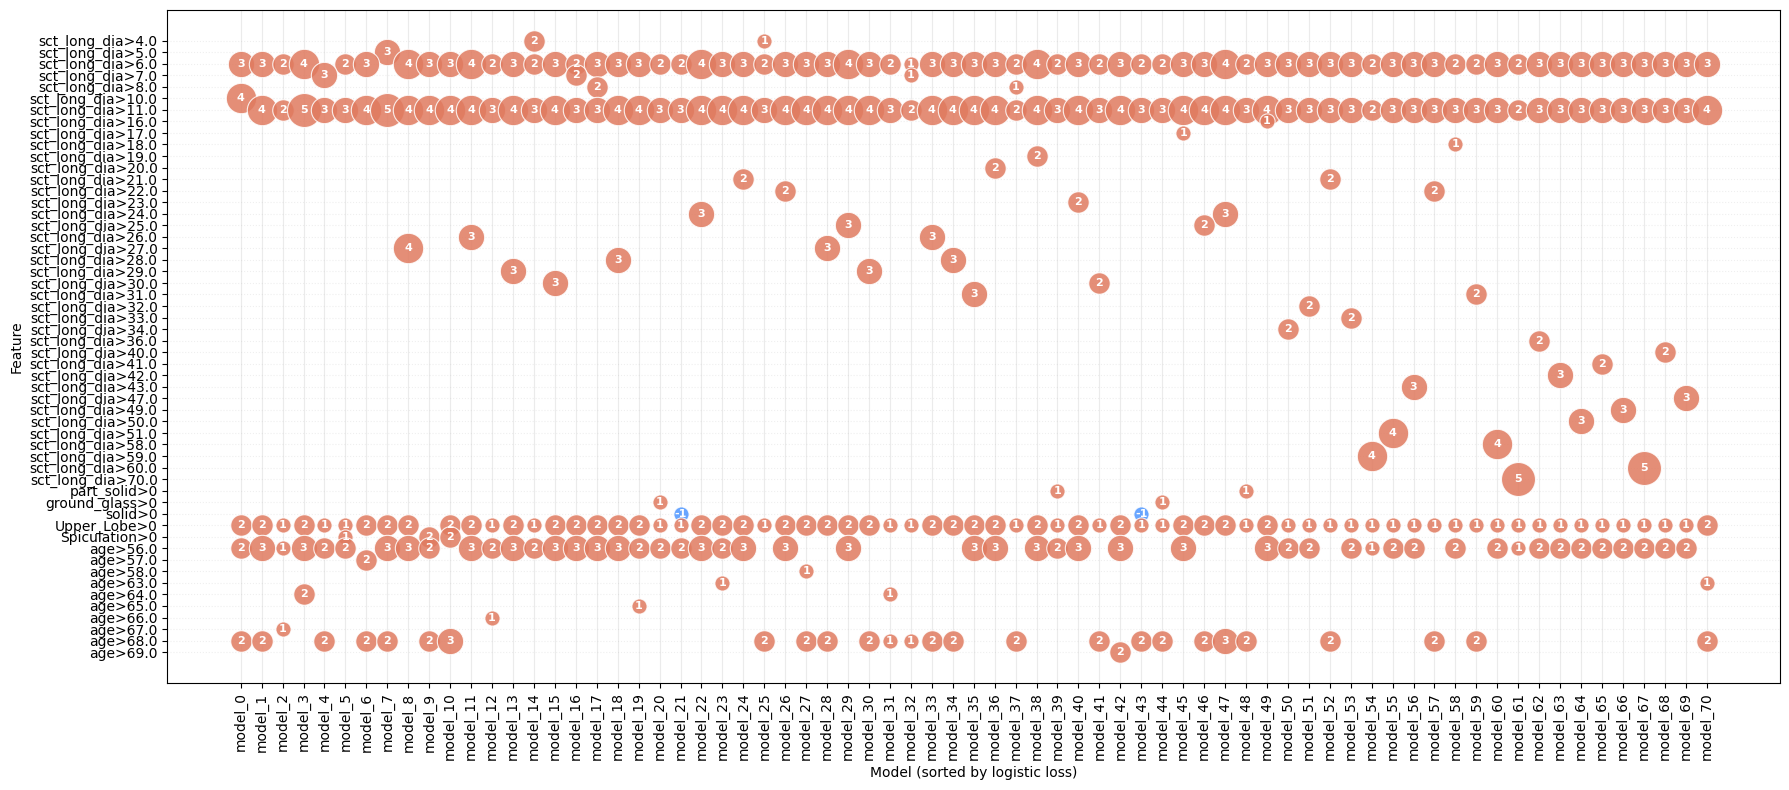

In [17]:
plot_feature_model_matrix(feature_model_df)

尝试不同的超参数，检查是否还是集中。 try different hyperparameter sets and see if feature sets are still similar

In [ ]:
# Exhaustive grid search over hyperparameters and save plots for each run
import itertools
import signal

ks = [4, 5, 6]
gap_tolerances = [0.05, 0.02]
parent_sizes = [8, 10, 12]
select_top_ms = [50, 71, 80]
num_ray_searchs = [10, 20, 30]

os.makedirs("image", exist_ok=True)

combos = list(itertools.product(ks, gap_tolerances, parent_sizes, select_top_ms, num_ray_searchs))

results = []

for idx, (k, gap_tolerance, parent_size, select_top_m, num_ray_search) in enumerate(combos, start=1):
    label = f"k{k}_gap{str(gap_tolerance).replace('.', 'p')}_ps{parent_size}_m{select_top_m}_nrs{num_ray_search}"
    
    try:
        start = time.time()
        multipliers, beta0_int, betas_int = run_fasterrisk(
            X_train=X_train_STLMD,
            y_train=y_train_STLMD,
            k=k,
            gap_tolerance=gap_tolerance,
            parent_size=parent_size,
            select_top_m=select_top_m,
            maxAttempts=50,
            num_ray_search=num_ray_search,
            lineSearch_early_stop_tolerance=1e-3,
            lb=-5,
            ub=5,
            verbose=False,
        )
        elapsed = time.time() - start

        # Build feature-model dataframe
        feature_names = X_train_STLMD_bin.columns
        feature_model_df = build_feature_model_matrix(betas_int, feature_names=feature_names)
        feature_model_df = feature_model_df[(feature_model_df != 0).any(axis=1)]

        # Save plot
        fname = os.path.join("image", f"{idx:03d}_{label}.png")
        plot_feature_model_matrix(feature_model_df, save_path=fname)

        results.append({
            "idx": idx,
            "label": label,
            "k": k,
            "gap_tolerance": gap_tolerance,
            "parent_size": parent_size,
            "select_top_m": select_top_m,
            "num_ray_search": num_ray_search,
            "models_count": len(multipliers),
            "runtime_s": elapsed,
            "image": fname,
        })
    except Exception as e:
        print(f"✗ Error in {label}: {e}")
        continue

print(f"\n\n=== GRID SEARCH COMPLETE ===")

我们发现不管是使用什么超参数，feature set依然相似。We can find that the features sets are still similar among all hyperparameter sets.

## Why so similar?

Do a simple random forest to test whether they are actually the most important features.

In [18]:
# Train a Random Forest and compute Mean Decrease in Impurity (MDI)
from sklearn.ensemble import RandomForestClassifier

# Fit RF on training data (X_train_STLMD: ndarray, y_train_STLMD: ndarray)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_STLMD, y_train_STLMD)

feature_names = list(X_train_STLMD_bin.columns)

importances = rf.feature_importances_
mdi_df = pd.DataFrame({"feature": feature_names, "mdi": importances})
mdi_df = mdi_df.sort_values("mdi", ascending=False).reset_index(drop=True)

print("Top features by MDI:")
print(mdi_df.head(20).to_string(index=False))

Top features by MDI:
          feature      mdi
            sex>0 0.106960
     Upper_Lobe>0 0.092900
    Spiculation>0 0.071528
     part_solid>0 0.046725
          solid>0 0.027536
sct_long_dia>11.0 0.027178
   ground_glass>0 0.026637
sct_long_dia>10.0 0.026370
         age>61.0 0.025903
 sct_long_dia>7.0 0.025137
         age>62.0 0.024699
 sct_long_dia>9.0 0.024694
         age>59.0 0.024456
 sct_long_dia>8.0 0.024208
         age>60.0 0.022305
         age>64.0 0.021348
 sct_long_dia>6.0 0.021229
sct_long_dia>12.0 0.021060
         age>66.0 0.020868
         age>58.0 0.020579


Strange: Sex and part_solid are very important in random forest, but they hardly receive high weights in FasterRisk.

In [19]:
# Train a Random Forest and compute Mean Decrease in Impurity (MDI)
from sklearn.ensemble import RandomForestClassifier

# Fit RF on training data (X_train_STLMD: ndarray, y_train_STLMD: ndarray)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_STLMD_df, y_train_STLMD)

feature_names = list(X_train_STLMD_df.columns)

importances = rf.feature_importances_
mdi_df = pd.DataFrame({"feature": feature_names, "mdi": importances})
mdi_df = mdi_df.sort_values("mdi", ascending=False).reset_index(drop=True)

print("Top features by MDI:")
print(mdi_df.head(20).to_string(index=False))

Top features by MDI:
     feature      mdi
sct_long_dia 0.446547
         age 0.413693
         sex 0.038783
 Spiculation 0.034214
  Upper_Lobe 0.031228
  part_solid 0.019086
ground_glass 0.008738
       solid 0.007711


## Why age?

what we do is actually examine the relationship between the age and lung cancer. But intuitively, as age increasing, the probability of all cancer will increase, not only lung cancer. It is somehow like a bayesian thing, maybe we need data including P(lung cancer|all cancer) and P(all cancer|age)

## Why Long Diameter?

Guess: Maybe there is some conventional rules?

## ROC for every feature

✓ ROC curves saved to image/roc_curves_continuous_features.png


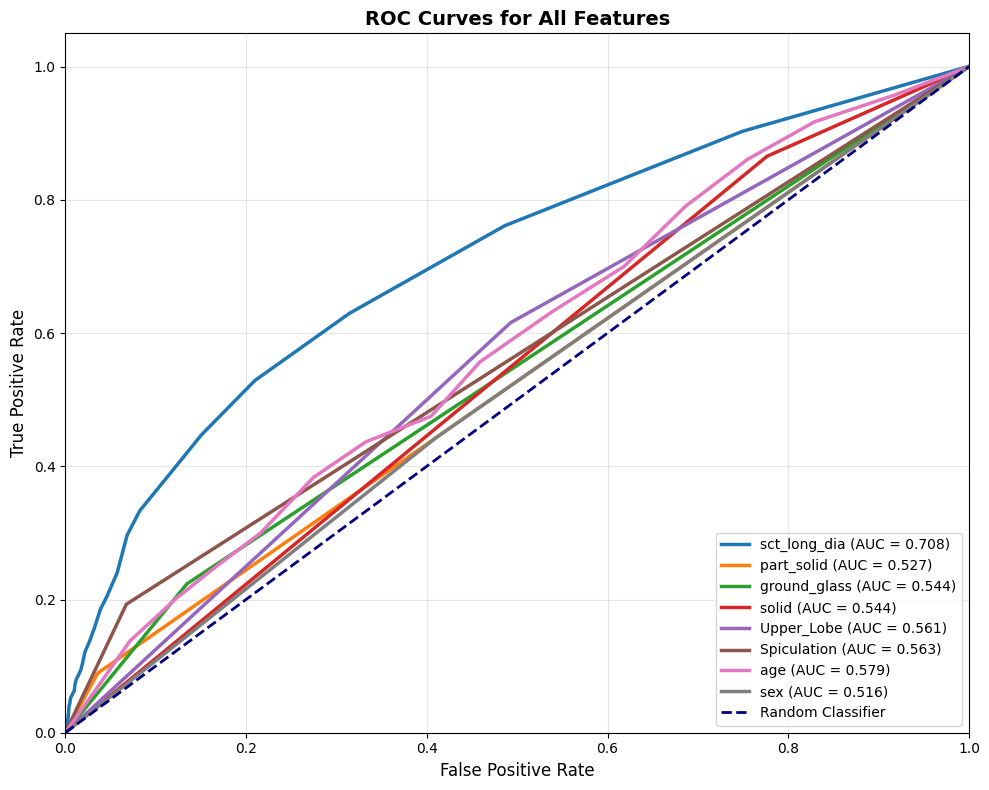


ROC Curve Summary (Continuous Features)
Total features: 8
Valid features (AUC ≠ 0.5): 8
Skipped features (AUC = 0.5): 0

AUC Scores for each feature (sorted):
----------------------------------------
sct_long_dia        : 0.7084
age                 : 0.5790
Spiculation         : 0.5626
Upper_Lobe          : 0.5614
ground_glass        : 0.5444
solid               : 0.5444
part_solid          : 0.5268
sex                 : 0.5163


In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# Plot ROC curve for each feature using original continuous features
features = X_train_STLMD_df.columns

# Calculate all ROC curves and their AUC scores
roc_data = []
skipped = []

for feature in features:
    X_feature = X_train_STLMD_df[feature].values
    y_binary = np.where(y_train_STLMD == 1, 1, 0)
    
    fpr, tpr, _ = roc_curve(y_binary, X_feature)
    roc_auc = auc(fpr, tpr)
    
    # Skip if AUC == 0.5
    if abs(roc_auc - 0.5) < 1e-6:
        skipped.append(f"{feature} (AUC = {roc_auc:.4f})")
        continue
    
    # Flip if AUC < 0.5 (flip along y=x)
    if roc_auc < 0.5:
        fpr, tpr = tpr, fpr
        roc_auc = auc(fpr, tpr)
    
    roc_data.append({
        'feature': feature,
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    })

valid_count = len(roc_data)

# Create a single figure with all ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for different features
colors = plt.cm.tab10(range(valid_count))

for idx, data in enumerate(roc_data):
    ax.plot(data['fpr'], data['tpr'], color=colors[idx], lw=2.5, 
            label=f"{data['feature']} (AUC = {data['auc']:.3f})")

# Plot diagonal line
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves for All Features', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
os.makedirs("image", exist_ok=True)
save_path = "image/roc_curves_continuous_features.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ ROC curves saved to {save_path}")

plt.show()

# Print summary
print("\n" + "=" * 50)
print("ROC Curve Summary (Continuous Features)")
print("=" * 50)
print(f"Total features: {len(features)}")
print(f"Valid features (AUC ≠ 0.5): {valid_count}")
print(f"Skipped features (AUC = 0.5): {len(skipped)}")

if skipped:
    print("\nSkipped features:")
    for s in skipped:
        print(f"  - {s}")

print("\nAUC Scores for each feature (sorted):")
print("-" * 40)
roc_data_sorted = sorted(roc_data, key=lambda x: x['auc'], reverse=True)
for data in roc_data_sorted:
    print(f"{data['feature']:20s}: {data['auc']:.4f}")